# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

In [9]:
dev_paths['fan']['train'][-1]

'/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/add_dev_data/fan/train/section_05_target_train_normal_0002_strength_1_temp_max.wav'

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'])
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict['model'], strict=False)
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# run

In [12]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-04-09 15:40:11,918 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-04-09 15:40:11,920 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:40:11,921 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]
2021-04-09 15:41:50,170 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/fan_features.pkl
2021-04-09 15:41:50,178 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-04-09 15:41:50,179 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:41:50,180 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 98.253977776 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]
2021-04-09 15:44:04,144 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/gearbox_features.pkl
2021-04-09 15:44:04,166 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-04-09 15:44:04,167 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:44:04,167 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 133.982120275 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
2021-04-09 15:46:08,414 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/pump_features.pkl
2021-04-09 15:46:08,444 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-04-09 15:46:08,445 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:46:08,446 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 124.265542746 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
2021-04-09 15:48:00,594 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/slider_features.pkl
2021-04-09 15:48:00,621 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-04-09 15:48:00,622 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:48:00,623 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 112.165178537 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]
2021-04-09 15:49:33,346 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/ToyCar_features.pkl
2021-04-09 15:49:33,373 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-04-09 15:49:33,374 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:49:33,375 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 92.740906954 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
2021-04-09 15:51:22,649 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/ToyTrain_features.pkl
2021-04-09 15:51:22,659 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-04-09 15:51:22,660 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-09 15:51:22,661 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 109.277157545 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]
2021-04-09 15:53:03,953 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/extraction_features/valve_features.pkl


elapsed time: 101.312847137 [sec]


In [13]:
machine_type = 'pump'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

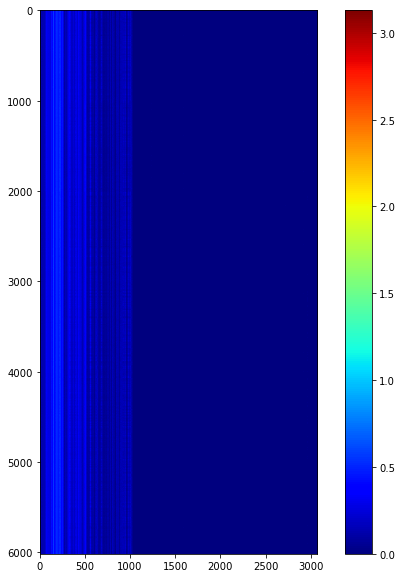

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

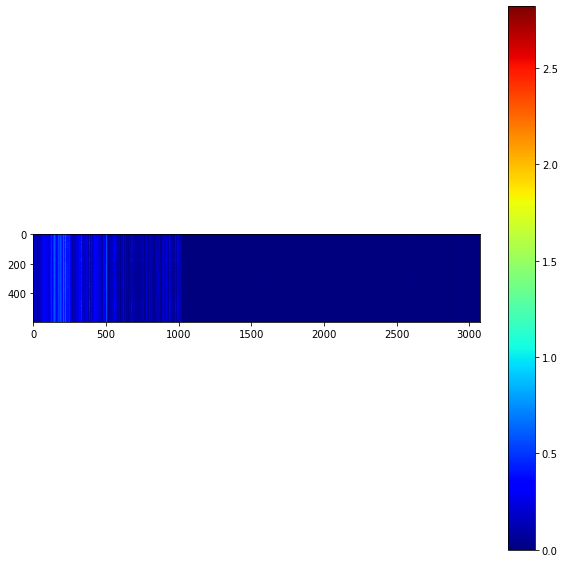

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_source']['features'], cmap='jet')
plt.colorbar()

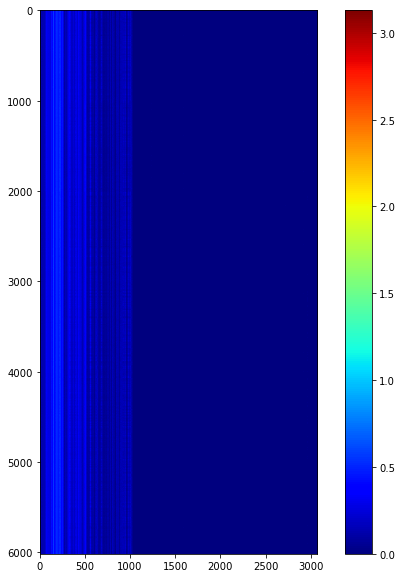

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)

In [17]:
print(M_means.shape)
plt.imshow(M_means, aspect='auto', cmap='jet')
plt.title(phase)
plt.colorbar()
plt.show()

NameError: name 'M_means' is not defined